In [ ]:
%pip install patool
import patoolib
import pandas as pd
import numpy as np
import requests
import os
from keras.datasets import cifar10
import cv2

from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


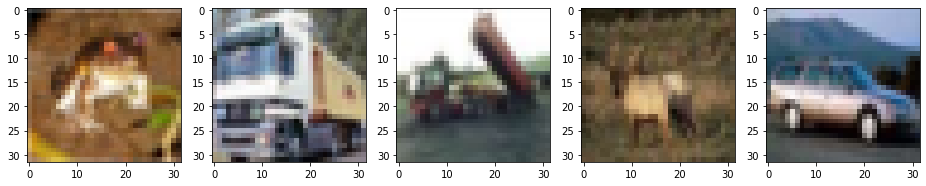

In [ ]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

In [ ]:
# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3) (flatten the arrays)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# zero-centering of pixel values using mean FROM THE TRAINING SET (IMPORTANT)

X_train -= np.mean(X_train, axis = 0)
X_test -= np.mean(X_train, axis = 0)

#Unnormalized set
X_train_unnormalized = X_train

# Normalization of RGB pixel values (to [0-1] range)

X_train /= 255
X_test /= 255


#get the training data covariance matrix

cov = np.dot(X_train.T, X_train) / X_train.shape[0]

#compute the SVD factorization of the data covariance matrix

U,S,V = np.linalg.svd(cov)

#Decorrelate the data 

X_train_rot = np.dot(X_train, U) 
X_test_rot = np.dot(X_test, U) 

#Xrot_reduced becomes [N x 100] (PCA DIMENSION REDUCTION)

#X_train_rot_reduced = np.dot(X_train_rot, U[:,:100])
#X_test_rot_reduced = np.dot(X_test_rot, U[:,:100]) 

##Data Whitening (On the PCA filtered data)

epsilon = 1e-5

#Divide by the eigenvalues (which are square roots of the singular values) P.S smoothing data by choosing a larger epsilon
Xwhite_train = X_train_rot / np.sqrt(S + epsilon)
Xwhite_test = X_test_rot / np.sqrt(S + epsilon)

In [ ]:
N, D = Xwhite_train.shape
d = D//3

x_train=Xwhite_train.reshape(50000, 32, 32, 3)

x_test=Xwhite_test.reshape(10000, 32, 32, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model
#include_top = false removes the fully connected layers

resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the convolutional layers
resnet_model.trainable = False

x = tf.keras.layers.Flatten()(resnet_model.output)

# Remove the fully connected layers
print(resnet_model.summary)

# Add fully connected layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the new model
model = tf.keras.models.Model(inputs=resnet_model.input, outputs=x)
#(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
#train_labels = tf.keras.utils.to_categorical(train_labels)
#test_labels = tf.keras.utils.to_categorical(test_labels)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7ff9ac7c39a0>>


In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 353s 224ms/step - loss: 2.2377 - accuracy: 0.1501 - val_loss: 1.3482 - val_accuracy: 0.5436
Epoch 2/10
1563/1563 [==============================] - 335s 214ms/step - loss: 2.1969 - accuracy: 0.1733 - val_loss: 1.3847 - val_accuracy: 0.5278
Epoch 3/10
1563/1563 [==============================] - 319s 204ms/step - loss: 2.1852 - accuracy: 0.1776 - val_loss: 1.4154 - val_accuracy: 0.5175
Epoch 4/10
1563/1563 [==============================] - 285s 182ms/step - loss: 2.1797 - accuracy: 0.1827 - val_loss: 1.4597 - val_accuracy: 0.5065
Epoch 5/10
1563/1563 [==============================] - 321s 205ms/step - loss: 2.1761 - accuracy: 0.1835 - val_loss: 1.5284 - val_accuracy: 0.4810
Epoch 6/10
1563/1563 [==============================] - 279s 179ms/step - loss: 2.1703 - accuracy: 0.1862 - val_loss: 1.4854 - val_accuracy: 0.4943
Epoch 7/10
1563/1563 [==============================] - 280s 179ms/step - loss: 2.1699 - accuracy: 0.1887 - val_

Text(0.5, 0, 'epoch')

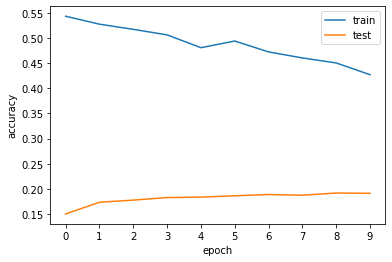

In [ ]:
import numpy as np
test_accuracy = [0.1501,0.1733, 0.1776, 0.1827, 0.1835, 0.1862, 0.1887, 0.1873, 0.1917, 0.1911]
train_accuracy = [0.5436, 0.5278, 0.5175, 0.5065, 0.4810, 0.4943, 0.4726, 0.4606, 0.4506, 0.4273]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model
#include_top = false removes the fully connected layers

resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the convolutional layers
resnet_model.trainable = False

x = tf.keras.layers.Flatten()(resnet_model.output)

# Remove the fully connected layers
print(resnet_model.summary)

# Add fully connected layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the new model
model = tf.keras.models.Model(inputs=resnet_model.input, outputs=x)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))



<bound method Model.summary of <keras.engine.functional.Functional object at 0x7ff916e3a280>>
Epoch 1/10
1563/1563 [==============================] - 358s 224ms/step - loss: 1.2929 - accuracy: 0.5469 - val_loss: 1.1452 - val_accuracy: 0.5995
Epoch 2/10
1563/1563 [==============================] - 338s 216ms/step - loss: 1.0693 - accuracy: 0.6228 - val_loss: 1.1614 - val_accuracy: 0.5956
Epoch 3/10
1563/1563 [==============================] - 286s 183ms/step - loss: 0.9788 - accuracy: 0.6550 - val_loss: 1.1106 - val_accuracy: 0.6144
Epoch 4/10
1563/1563 [==============================] - 285s 182ms/step - loss: 0.9018 - accuracy: 0.6787 - val_loss: 1.1082 - val_accuracy: 0.6220
Epoch 5/10
1563/1563 [==============================] - 277s 177ms/step - loss: 0.8342 - accuracy: 0.7021 - val_loss: 1.1859 - val_accuracy: 0.6139
Epoch 6/10
1563/1563 [==============================] - 281s 180ms/step - loss: 0.7608 - accuracy: 0.7291 - val_loss: 1.1782 - val_accuracy: 0.6180
Epoch 7/10
1563/15

Text(0.5, 0, 'epoch')

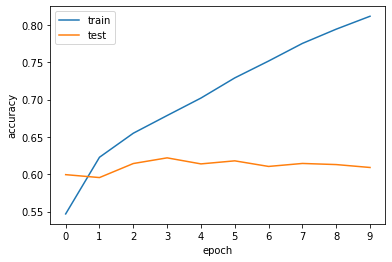

In [ ]:
import numpy as np
test_accuracy = [0.5995,0.5956,0.6144,0.6220,0.6139,0.6180,0.6105,0.6145,0.6130,0.6091]
train_accuracy = [0.5469,0.6228,0.6550,0.6787,0.7021,0.7291,0.7517,0.7753,0.7944,0.8117]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model
#include_top = false removes the fully connected layers

resnet_model2 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the convolutional layers
resnet_model2.trainable = False

x = tf.keras.layers.Flatten()(resnet_model2.output)

# Remove the fully connected layers
print(resnet_model2.summary)

# Add fully connected layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)


# Create the new model
model2 = tf.keras.models.Model(inputs=resnet_model2.input, outputs=x)

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7ff9ac7bb0d0>>


In [ ]:
model2.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 292s 184ms/step - loss: 1.2942 - accuracy: 0.5523 - val_loss: 1.2042 - val_accuracy: 0.5741
Epoch 2/10
1563/1563 [==============================] - 315s 202ms/step - loss: 1.0575 - accuracy: 0.6277 - val_loss: 1.1388 - val_accuracy: 0.6117
Epoch 3/10
1563/1563 [==============================] - 329s 210ms/step - loss: 0.9716 - accuracy: 0.6545 - val_loss: 1.1389 - val_accuracy: 0.6138
Epoch 4/10
1563/1563 [==============================] - 279s 178ms/step - loss: 0.9012 - accuracy: 0.6795 - val_loss: 1.1697 - val_accuracy: 0.6111
Epoch 5/10
1563/1563 [==============================] - 297s 190ms/step - loss: 0.8320 - accuracy: 0.7044 - val_loss: 1.1380 - val_accuracy: 0.6232
Epoch 6/10
1563/1563 [==============================] - 323s 207ms/step - loss: 0.7638 - accuracy: 0.7278 - val_loss: 1.1943 - val_accuracy: 0.6155
Epoch 7/10
1563/1563 [==============================] - 323s 207ms/step - loss: 0.7038 - accuracy: 0.7485 - val_

Text(0.5, 0, 'epoch')

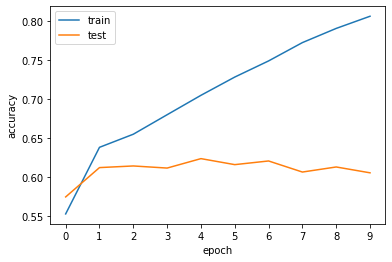

In [ ]:
import numpy as np
test_accuracy = [0.5741,0.6117,0.6138,0.6111,0.6232,0.6155,0.6202,0.6060,0.6125,0.6050]
train_accuracy = [0.5523,0.6377,0.6545,0.6795,0.7044,0.7278,0.7485,0.7720,0.7902,0.8058]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the ResNet50 model
#include_top = false removes the fully connected layers

resnet_model3 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the convolutional layers
resnet_model3.trainable = False

x = tf.keras.layers.Flatten()(resnet_model2.output)

# Remove the fully connected layers

# Add fully connected layers
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="softmax")(x)

# Create the new model
model3 = tf.keras.models.Model(inputs=resnet_model2.input, outputs=x)

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 340s 214ms/step - loss: 1.2907 - accuracy: 0.5515 - val_loss: 1.1477 - val_accuracy: 0.5942
Epoch 2/10
1563/1563 [==============================] - 365s 234ms/step - loss: 1.0608 - accuracy: 0.6271 - val_loss: 1.1441 - val_accuracy: 0.5986
Epoch 3/10
1563/1563 [==============================] - 364s 233ms/step - loss: 0.9594 - accuracy: 0.6603 - val_loss: 1.1217 - val_accuracy: 0.6216
Epoch 4/10
1563/1563 [==============================] - 363s 232ms/step - loss: 0.8749 - accuracy: 0.6886 - val_loss: 1.1505 - val_accuracy: 0.6230
Epoch 5/10
1563/1563 [==============================] - 392s 251ms/step - loss: 0.7782 - accuracy: 0.7215 - val_loss: 1.1907 - val_accuracy: 0.6144
Epoch 6/10
1563/1563 [==============================] - 367s 235ms/step - loss: 0.6927 - accuracy: 0.7501 - val_loss: 1.2467 - val_accuracy: 0.6181
Epoch 7/10
1563/1563 [==============================] - 364s 233ms/step - loss: 0.6147 - accuracy: 0.7788 - val_

Text(0.5, 0, 'epoch')

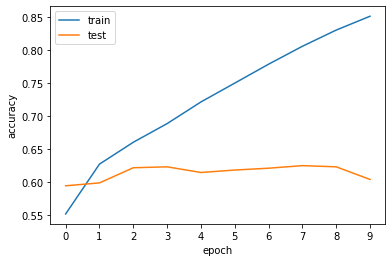

In [ ]:
import numpy as np
test_accuracy = [0.5942,0.5986, 0.6216,0.6230,0.6144,0.6181,0.6209,0.6248,0.6230,0.6038]
train_accuracy = [0.5515,0.6271,0.6603,0.6886,0.7215,0.7501,0.7788,0.8060,0.8306,0.8516]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')